### Test spectral inversion with griffin-lim

#### load spectrogram dataframe

In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms
from avgn.visualization.spectrogram import draw_spec_set
from avgn.visualization.quickplots import draw_projection_plots

### Collect data

In [5]:
import urllib.request
import io
import soundfile as sf
from IPython.display import display, Audio

In [6]:
url = "https://raw.githubusercontent.com/timsainb/python_spectrograms_and_inversion/master/bushOffersPeace.wav"

In [7]:
response = urllib.request.urlopen(url)
signal, rate = sf.read(io.BytesIO(response.read()))

In [8]:
display(Audio(signal, rate=rate))

In [9]:
from avgn.utils.hparams import HParams

### Griffin Lim Inversion

In [10]:
# normal librosa
import librosa
S = np.abs(librosa.stft(signal))
y_inv = librosa.griffinlim(S)
display(Audio(y_inv, rate=rate))

##### griffin lim on compressed spec

In [49]:
from avgn.signalprocessing.spectrogramming import (
    spectrogram, melspectrogram, inv_spectrogram, _build_mel_basis,
    _build_mel_inversion_basis, spectrogram_librosa, inv_spectrogram_librosa, _mel_to_linear)

In [50]:
hparams = HParams(
    num_mels = 128,
    mel_lower_edge_hertz=50,
    mel_upper_edge_hertz=8000,
    dynamic_range_dB = 50,
    hop_length_ms = 4,
    win_length_ms = 20,
    ref_level_db=20,
    n_fft=2048,
    min_level_db=-60,
    griffin_lim_iters=200
)

In [51]:
_mel_basis = _build_mel_basis(hparams, rate, rate)
_mel_inversion_basis = _build_mel_inversion_basis(_mel_basis)

In [52]:
spec = spectrogram_librosa(signal, rate, hparams)

In [53]:
melspec = melspectrogram(signal, rate, hparams, _mel_basis)
mel_inv_spec = _mel_to_linear(melspec, _mel_inverse_basis = _mel_inversion_basis)

In [54]:
signal_inv = inv_spectrogram_librosa(spec, rate, hparams)

In [55]:
signal_mel_inv = inv_spectrogram_librosa(mel_inv_spec, rate, hparams)

In [56]:
display(Audio(signal_inv, rate=rate))

In [57]:
display(Audio(signal_mel_inv, rate=rate))

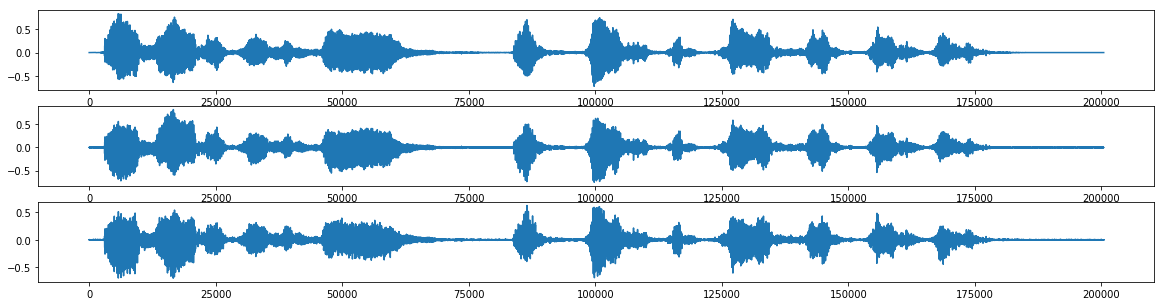

In [58]:
fig, axs = plt.subplots(nrows=3, figsize=(20,5))
axs[0].plot(signal[:len(signal_inv)])
axs[1].plot(signal_inv)
axs[2].plot(signal_mel_inv)

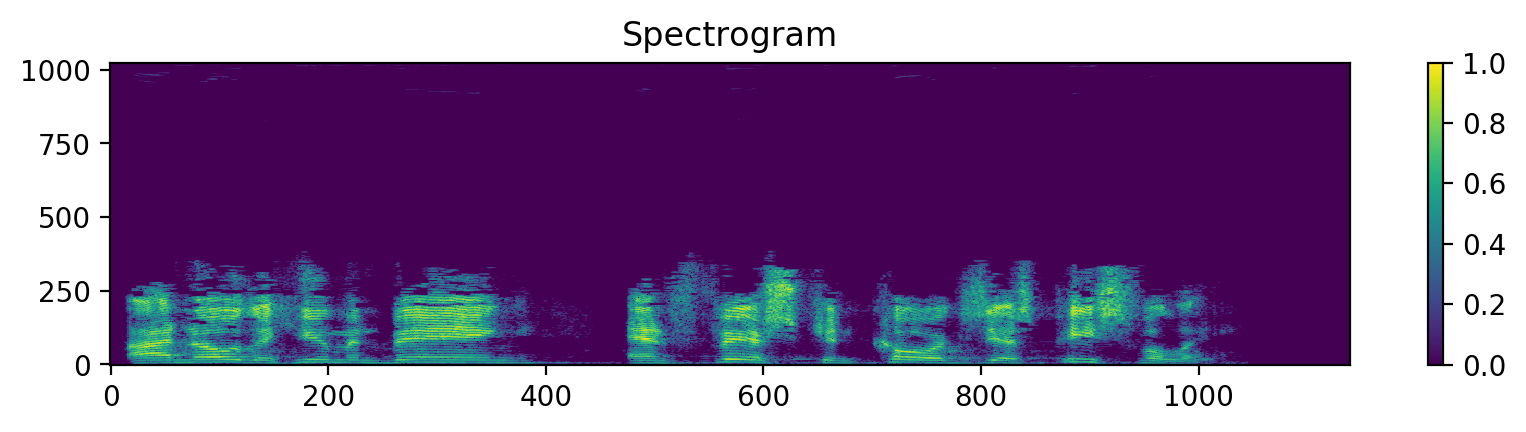

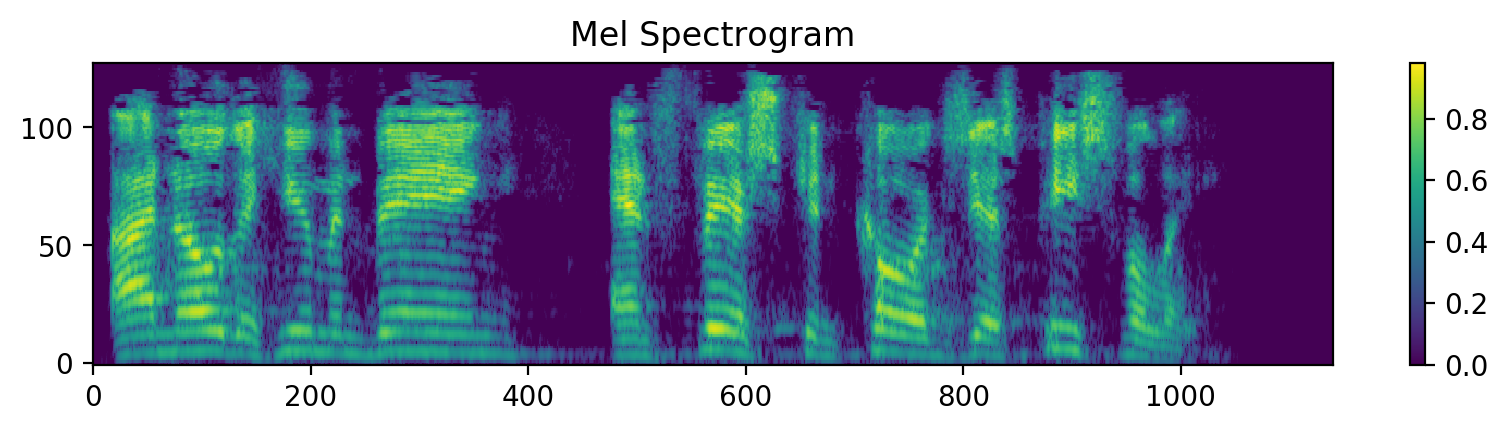

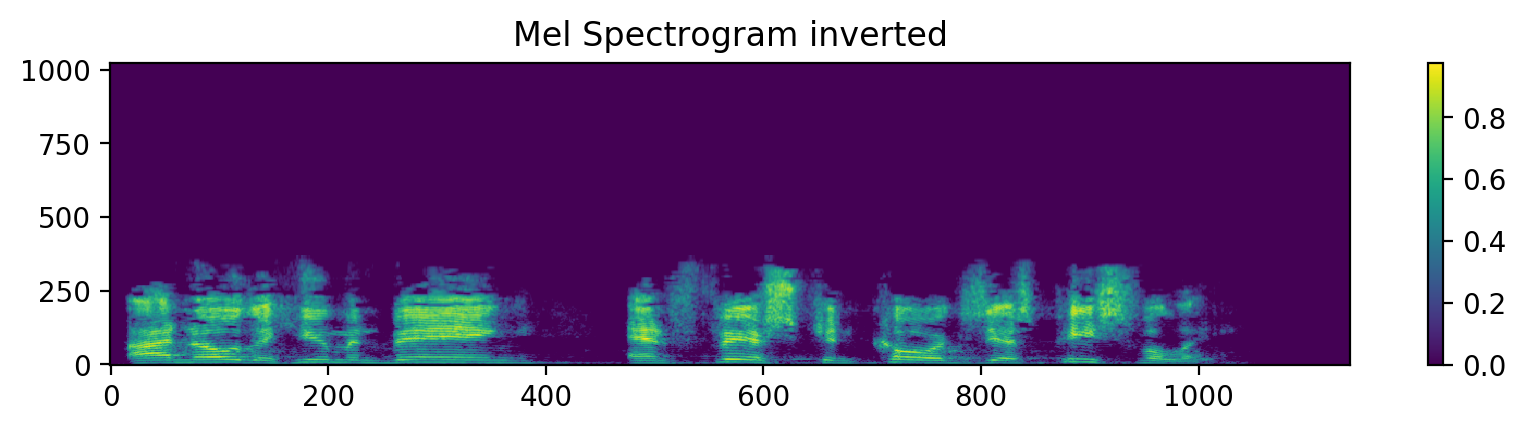

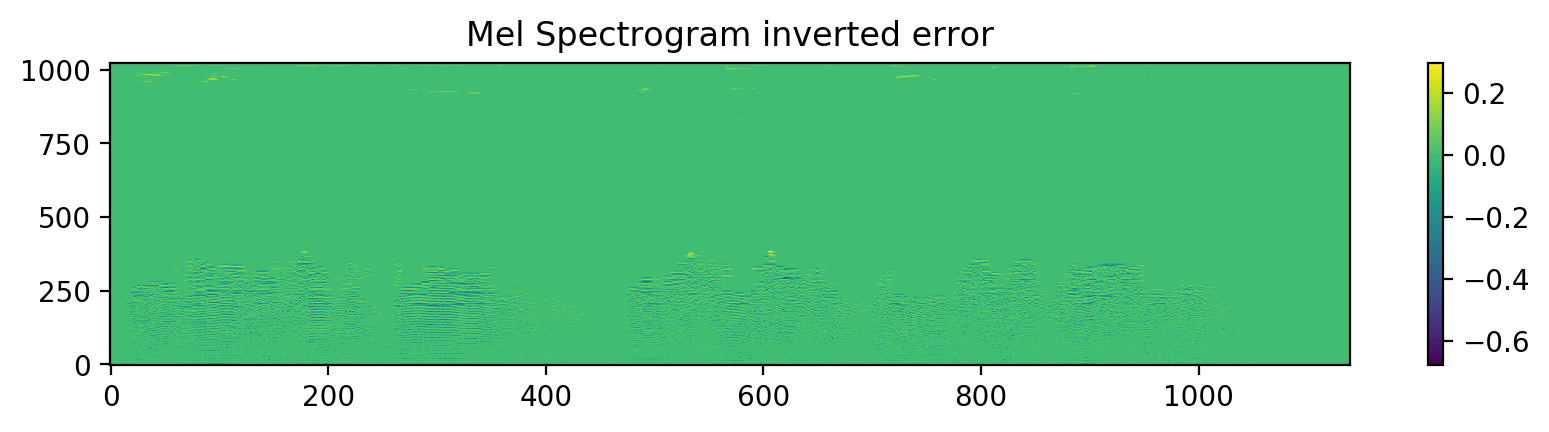

In [59]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig = plt.figure(dpi=200, figsize=(10,2))
im = plt.imshow(spec, origin="lower", aspect="auto")
fig.colorbar(im)
plt.title('Spectrogram')

fig = plt.figure(dpi=200, figsize=(10,2))
im2 = plt.imshow(melspec, origin="lower", aspect="auto")
plt.title('Mel Spectrogram')
plt.colorbar(im2)

fig = plt.figure(dpi=200, figsize=(10,2))
im3 = plt.imshow(mel_inv_spec, origin="lower", aspect="auto")
plt.title('Mel Spectrogram inverted')
fig.colorbar(im3)
plt.show()

fig = plt.figure(dpi=200, figsize=(10,2))
im3 = plt.imshow(spec - mel_inv_spec, origin="lower", aspect="auto")
plt.title('Mel Spectrogram inverted error')
fig.colorbar(im3)
plt.show()